In [1]:
from collections import defaultdict
import pandas as pd
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
ysd_measure = pd.read_csv('data/05_ysd_low-throughput_measurements.csv')

lib = pd.read_csv('designs.csv')
lib.set_index('seq_id', drop=False, inplace=True)
ysd_measure.set_index('seq_id', inplace=True, drop=False)

Normalize raw MFU measurements by subtracting out background measured in unlabelled yeast control and dividing by WT MFU value.

In [3]:
# set index to Clone
ysd_measure.set_index('Clone', inplace=True, drop=False)

# background MFU from unabelled yeast control
display_bkgd = ysd_measure.loc['unlabelled_yeast_cntrl', 'Raw MFU Display']
bind_bkgd = ysd_measure.loc['unlabelled_yeast_cntrl', 'Raw MFU IgG Bind']

# WT raw bind and display MFU
wt_display = ysd_measure.loc['wt', 'Raw MFU Display']
wt_bind = ysd_measure.loc['wt', 'Raw MFU IgG Bind']

# calculate Normalized MFU display: (raw MFU - MFU bkgd) / (wt MFU - MFU bkgd)
ysd_measure['Normalized MFU Display'] = (ysd_measure['Raw MFU Display'] - display_bkgd) / (wt_display - display_bkgd)
ysd_measure['Normalized MFU IgG Bind'] = (ysd_measure['Raw MFU IgG Bind'] - bind_bkgd) / (wt_bind - bind_bkgd)

Get model and mutations for high bind designs.

In [4]:
ysd_measure.set_index('seq_id', inplace=True, drop=False)
hb_ids = ysd_measure[ysd_measure.Group == '5-10 mutants in "high bind" population'].seq_id
pd.concat([lib.loc[hb_ids, ['model', 'num_mut',]], ysd_measure.loc[hb_ids, ['Normalized MFU Display', 'Normalized MFU IgG Bind']]], axis=1)

,model,num_mut,Normalized MFU Display,Normalized MFU IgG Bind
seq_id,,,,
seq_40,FCN,5,0.968652,1.304613
seq_184,EnsC,5,1.062696,1.435161
seq_195,EnsC,5,0.937304,1.304613
seq_308,CNN2,5,1.062696,2.566580
seq_559,CNN0,10,1.532915,3.132289


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


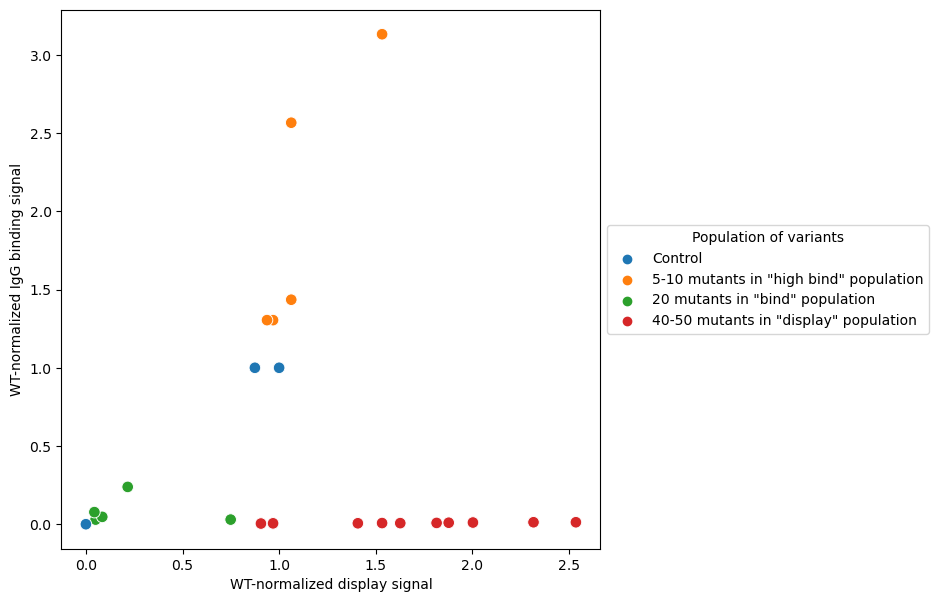

In [5]:
# fig 5a
plt.figure(figsize=(10,7))
sns.scatterplot(data=ysd_measure, x='Normalized MFU Display', y='Normalized MFU IgG Bind', hue='Group', s=70)
plt.ylabel('WT-normalized IgG binding signal')
plt.xlabel('WT-normalized display signal')
plt.legend(title='Population of variants', loc='center left', bbox_to_anchor=(1, 0.5))
ax = plt.gca()
ax.set_box_aspect(1)
plt.savefig('plots/yeast_display_low_throughput.eps', format='eps')

Save source data for Figure 5a

In [6]:
src_df = ysd_measure[['Clone', 'seq_id', 'Group', 'Normalized MFU Display', 'Normalized MFU IgG Bind', 'Name']].copy().reset_index(drop=True)
src_df.to_csv('source_data_files/fig_5a_src.csv')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


,clones,Kd,Max Signal
0,WT,1.34,8.95
1,Design10,0.93,12.01
2,FCN-5,0.95,13.43
3,EnsC-5,1.71,14.27
4,CNN-10,1.10,20.62
5,EnsC-20,6.89,7.65


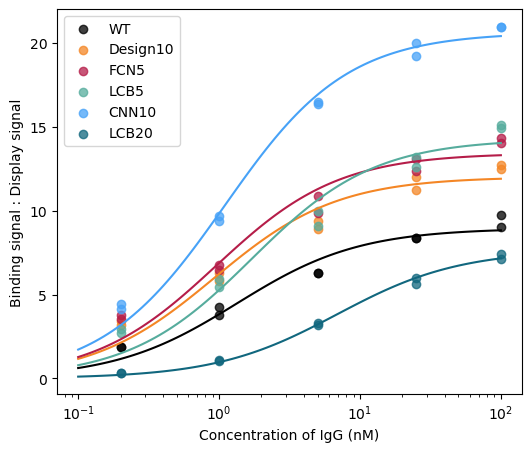

In [7]:
# fig 5b
files = ['data/ysd_bind1.csv', 'data/ysd_bind2.csv']
clones = ['WT', 'Design10', 'FCN-5', 'EnsC-5', 'CNN-10', 'EnsC-20']

bind_data = defaultdict(list)
for file in files:
    with open(file, 'r') as f:
        raw_data = [row.split(',') for row in f.read().split('\n')]
        # print(raw_data)
        for row in raw_data[1:]:
            # print(row)
            for i in range(1, len(raw_data[0])):
                bind_data[row[0]].append([float(raw_data[0][i]), float(row[i])])
        
def fraction_bound(conc, kd, max_res):
    return conc/(conc+kd)*max_res

colors = ['k', '#f48625', '#B51D49', '#56AC9D', '#47A2F7', '#11677E']

plt.figure(figsize=(6,5))

kds = []
max_resps = []
for (clone, data), color in zip(bind_data.items(), colors):
    titers = list(zip(*data))[0]
    bind_sigs = list(zip(*data))[1]
    plt.scatter(titers, bind_sigs, label=clone, color=color, alpha=0.75)
    popt, pcov = curve_fit(fraction_bound, titers, bind_sigs, p0=[5, 100])
    max_resps.append(round(popt[1], 2))
    kds.append(round(popt[0], 2))
    fit_concentrations = np.logspace(-1, 2, 100)
    plt.plot(fit_concentrations, fraction_bound(fit_concentrations, *popt), color=color)
    
plt.xscale('log')
plt.xlabel('Concentration of IgG (nM)')
plt.ylabel('Binding signal : Display signal')
plt.legend()
plt.savefig('plots/binding_curves.eps', format='eps')

pd.DataFrame({'clones':clones, 'Kd':kds, 'Max Signal':max_resps})

Source data for Figure 5c in `data/ysd_bind1.csv` and `data/ysd_bind2.csv`.